In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

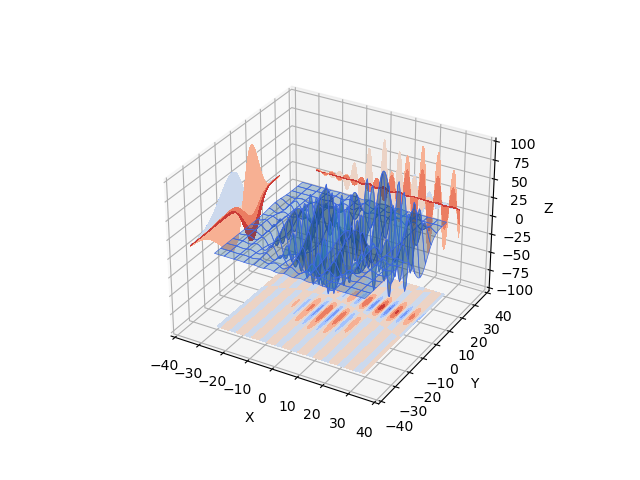

In [2]:
# set up plot
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(0, 2 * np.pi, 100)

def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))


@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    
    ax.clear() # clear canvas/ Remove old lines from plot and plot new one
    
    X, Y, Z = axes3d.get_test_data(0.05)

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z * my_sine(X, w, amp, phi), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Plot projections of the contours for each dimension.  We choose offsets
    # that match the appropriate axes limits. Projected contours sit on
    # the walls of the 3D graph
    ax.contourf(X, Y, Z* my_sine(X, w, amp, phi), zdir='z', offset=-100, cmap='coolwarm')
    ax.contourf(X, Y, Z* my_sine(X, w, amp, phi), zdir='x', offset=-40, cmap='coolwarm')
    ax.contourf(X, Y, Z* my_sine(X, w, amp, phi), zdir='y', offset=40, cmap='coolwarm')

    ax.set(xlim=(-40, 40), ylim=(-40, 40), zlim=(-100, 100),
           xlabel='X', ylabel='Y', zlabel='Z')